# Import packages

In [254]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from genetic_selection import GeneticSelectionCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay

df = pd.read_csv("sph6004_assignment1_data.csv")

Print out data shape to know how many patients and how many indicators

In [255]:
print(df.shape)
df.head()

(50920, 162)


,id,aki,gender,admission_age,race,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,...,ggt_max,ld_ldh_min,ld_ldh_max,gcs_min,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable,height,weight_admit
0,36570066,3,F,79.953141,BLACK/AFRICAN AMERICAN,96.0,104.0,100.083333,103.0,126.0,...,NaN,236.0,318.0,15.0,6.0,5.0,4.0,0.0,157.0,110.0
1,39307659,0,F,78.194169,WHITE - RUSSIAN,72.0,134.0,97.263158,97.0,127.0,...,NaN,NaN,NaN,15.0,6.0,5.0,4.0,0.0,NaN,82.0
2,38743306,2,F,65.602396,WHITE,60.0,97.0,84.166667,95.0,143.0,...,NaN,NaN,NaN,15.0,6.0,5.0,4.0,0.0,NaN,62.1
3,32339865,2,F,64.906629,UNKNOWN,59.0,87.0,71.461538,113.0,150.0,...,NaN,NaN,NaN,15.0,1.0,0.0,1.0,1.0,170.0,113.1
4,35526987,2,M,57.438861,WHITE,57.0,100.0,82.387097,81.0,127.0,...,NaN,NaN,NaN,15.0,NaN,0.0,1.0,1.0,178.0,97.4


## Key indicator check
Check whether all patients have aki in their data, otherwise delete that data. Find all patients have aki value

In [256]:
aki_nan_count = 0
for index, row in df.iterrows():
    if row['aki'] not in [0,1,2,3]:
        aki_nan_count += 1
print(aki_nan_count)

0


Create a function to check aki ratio, print raw aki ratio

In [257]:
def get_aki_ratio(df):
    aki_count = 0
    for each in df["aki"]:
        if each > 0:
            aki_count+=1
    aki_ratio = round(aki_count/(df.shape[0]), 4)*100
    print("aki count:", aki_count)
    print("aki ratio:",aki_ratio,"%")

get_aki_ratio(df)

aki count: 34060
aki ratio: 66.89 %


# Data Preprocessing
## Clean row data
1. As there are so many nan values in the csv file, I need to filter the patients first. Patients with too many nan is meaning less.
2. Here I set the threshold of nan-value ratio to 0.2 so patients need to have less and equal to 20% data that are nan.
3. Filter the data for next step processing (column cleaning)

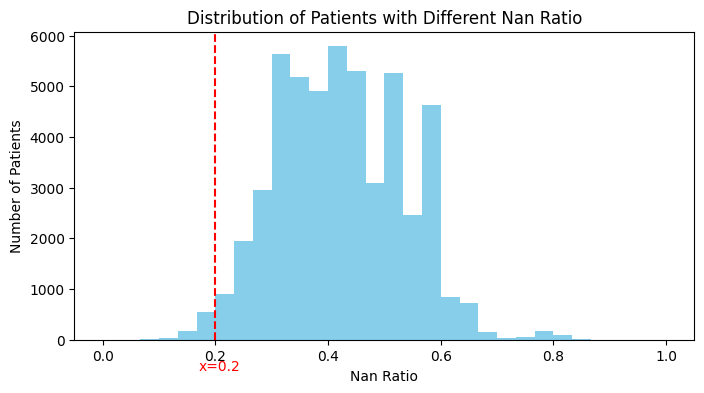

(746, 162)
aki count: 662
aki ratio: 88.74 %


In [258]:
df_row_nan_ratio = df.isnull().sum(axis=1) / len(df.columns)
row_threshold = 0.20
plt.figure(figsize=(8, 4))
plt.hist(df_row_nan_ratio.values, bins=30, range=(0, 1), color='skyblue')
plt.title('Distribution of Patients with Different Nan Ratio')
plt.xlabel('Nan Ratio')
plt.ylabel('Number of Patients')
plt.axvline(x=row_threshold, color='red', linestyle='--')
plt.text(row_threshold-0.03, -600, 'x='+str(row_threshold), color='red')
plt.show()

new_df_row_cleaning = df.loc[df_row_nan_ratio <= row_threshold, :]
print(new_df_row_cleaning.shape)
get_aki_ratio(new_df_row_cleaning)


## Clean column data
1. For some feature columns, the value is abnormal. So I show max and min value of each column to see whether it is rational.
2. After finding something unrational, then search online resource for some ranges. 
3. These following standard is considered for adults as the minimum age is 18 years old:
* heart rate should be around 40-220
* temperature should be around 34-43
* glucose should be around 40-200
* systolic blood pressure (SBP) should be around 80-200
* weight should be around 30-300
4. Reclean the row data
5. Set a threshold to clean column data

First, show max and min value of each column to see whether it is rational

In [259]:
# Create a DataFrame for max and min values for each column
df_max = pd.DataFrame(new_df_row_cleaning.max()).transpose()
df_min = pd.DataFrame(new_df_row_cleaning.min()).transpose()

# Concatenate vertically
result_df = pd.concat([df_max, df_min], axis=0)
result_df.head()

,id,aki,gender,admission_age,race,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,...,ggt_max,ld_ldh_min,ld_ldh_max,gcs_min,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable,height,weight_admit
0,39998012,3,M,95.671085,WHITE - RUSSIAN,143.0,254.0,161.44186,144.0,328.0,...,734.0,20500.0,63325.0,15.0,6.0,5.0,4.0,1.0,196.0,202.0
0,30006983,0,F,18.42365,ASIAN,2.0,56.0,49.44,12.0,84.0,...,14.0,87.0,107.0,3.0,1.0,0.0,1.0,0.0,147.0,1.0


In [260]:
manual_df = new_df_row_cleaning.copy()
# Change the unrational value to nan
heart_rate_list = ['heart_rate_min', 'heart_rate_max', 'heart_rate_mean']
temperature_rate_list = ['temperature_min', 'temperature_max', 'temperature_mean']
glucose_list = ['glucose_min', 'glucose_max', 'glucose_mean']
sbp_list = ['sbp_min', 'sbp_max', 'sbp_mean']

for each in heart_rate_list:
    manual_df.loc[(manual_df[each] > 220) | (manual_df[each] < 50), each] = np.nan

for each in temperature_rate_list:
    manual_df.loc[(manual_df[each] > 43)  | (manual_df[each] < 34), each] = np.nan

for each in glucose_list:
    manual_df.loc[(manual_df[each] > 200) | (manual_df[each] < 40), each] = np.nan

for each in sbp_list:
    manual_df.loc[(manual_df[each] > 200) | (manual_df[each] < 80), each] = np.nan

manual_df.loc[(manual_df['weight_admit'] > 300) | (manual_df['weight_admit'] < 30), 'weight_admit'] = np.nan
print("Shape before filter:", manual_df.shape)

manual_df_nan_ratio = manual_df.isnull().sum(axis=1) / len(manual_df.columns)
nan_count = 0
for each in manual_df_nan_ratio:
    if each >0.2:
        nan_count+=1
print("There are ", nan_count, "patients have more than 20% nan values in a total of", manual_df.shape[0], "patients")

manual_df = manual_df.loc[manual_df_nan_ratio <= row_threshold, :]
print("Shape after filter:", manual_df.shape)
get_aki_ratio(manual_df)

Shape before filter: (746, 162)
There are  208 patients have more than 20% nan values in a total of 746 patients
Shape after filter: (538, 162)
aki count: 475
aki ratio: 88.29 %


As there are some huge data loss in several feature columns, I need to set a threshold to only keep meaningful columns.

Like what I did in clean row data, I also do the distribution plot to see how is the nan value ratio for each feature column.

Threshold is set to 0.2, which means the tolerance of nan value of each column is 20%.

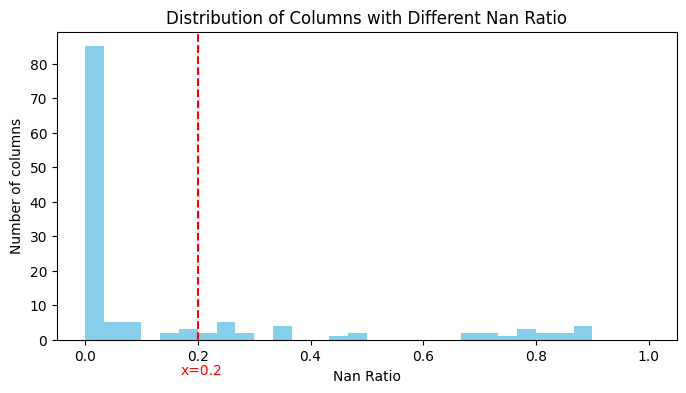

(538, 100)


,id,aki,gender,admission_age,race,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_max,sbp_mean,...,ast_min,ast_max,bilirubin_total_min,bilirubin_total_max,gcs_min,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable,weight_admit
129,31983116,3,F,20.909196,OTHER,94.0,136.0,115.031250,156.0,113.062500,...,83.0,152.0,1.9,2.5,15.0,6.0,5.0,4.0,0.0,95.5
270,30279527,3,M,28.544966,WHITE,59.0,86.0,75.487179,141.0,115.583333,...,1660.0,2082.0,0.4,0.7,15.0,1.0,0.0,1.0,1.0,100.0
289,34704061,3,F,55.870361,WHITE,95.0,111.0,99.636364,199.0,147.578947,...,43.0,59.0,0.4,0.6,14.0,6.0,4.0,4.0,0.0,190.0
324,37294629,3,M,69.752532,UNKNOWN,64.0,110.0,85.196970,152.0,108.303030,...,186.0,276.0,0.3,0.7,15.0,6.0,0.0,3.0,1.0,80.0
432,35835048,3,F,86.325441,WHITE,86.0,129.0,103.387097,173.5,120.750000,...,28.0,35.0,0.2,0.2,15.0,6.0,0.0,3.0,1.0,76.3


In [261]:
df_col_nan_ratio = manual_df.isnull().sum(axis=0) / len(manual_df.columns)
col_threshold = 0.2

plt.figure(figsize=(8, 4))
plt.hist(df_col_nan_ratio.values.flatten(), bins=30, range=(0, 1), color='skyblue')
plt.title('Distribution of Columns with Different Nan Ratio')
plt.xlabel('Nan Ratio')
plt.ylabel('Number of columns')
plt.axvline(x=col_threshold, color='red', linestyle='--')
plt.text(col_threshold-0.03, -10, 'x='+str(col_threshold), color='red')
plt.show()

new_df_column_cleaning = manual_df.loc[:, df_col_nan_ratio <= col_threshold]
# get_aki_ratio(new_df_column_cleaning)
print(new_df_column_cleaning.shape)
new_df_column_cleaning.head()

## Column Value Adjust
For column with name "race", I need to categorize each row as there are some ambiguous and repeatitive items inside.

In [262]:
new_df_after_cleaning = new_df_column_cleaning.copy()

for index, row in new_df_after_cleaning.iterrows():
    if "BLACK" in row['race']:
        new_df_after_cleaning.at[index, 'race'] = "BLACK"
    elif "WHITE" in row['race']:
        new_df_after_cleaning.at[index, 'race'] = "WHITE"
    elif "ASIAN" in row['race']:
        new_df_after_cleaning.at[index, 'race'] = "ASIAN"
    elif "HISPANIC" in row['race'] or "SOUTH AMERICAN" in row['race']:
        new_df_after_cleaning.at[index, 'race'] = "HISPANIC"
    elif "UNABLE" in row['race'] or "UNKNOWN" in row['race'] or "DECLINED" in row['race']:
        new_df_after_cleaning.at[index, 'race'] = "UNKNOWN"
    elif "PORTUGUESE" in row['race']:
        new_df_after_cleaning.at[index, 'race'] = "UNKNOWN"

print(new_df_after_cleaning.shape)
new_df_after_cleaning.head()

(538, 100)


,id,aki,gender,admission_age,race,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_max,sbp_mean,...,ast_min,ast_max,bilirubin_total_min,bilirubin_total_max,gcs_min,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable,weight_admit
129,31983116,3,F,20.909196,OTHER,94.0,136.0,115.031250,156.0,113.062500,...,83.0,152.0,1.9,2.5,15.0,6.0,5.0,4.0,0.0,95.5
270,30279527,3,M,28.544966,WHITE,59.0,86.0,75.487179,141.0,115.583333,...,1660.0,2082.0,0.4,0.7,15.0,1.0,0.0,1.0,1.0,100.0
289,34704061,3,F,55.870361,WHITE,95.0,111.0,99.636364,199.0,147.578947,...,43.0,59.0,0.4,0.6,14.0,6.0,4.0,4.0,0.0,190.0
324,37294629,3,M,69.752532,UNKNOWN,64.0,110.0,85.196970,152.0,108.303030,...,186.0,276.0,0.3,0.7,15.0,6.0,0.0,3.0,1.0,80.0
432,35835048,3,F,86.325441,WHITE,86.0,129.0,103.387097,173.5,120.750000,...,28.0,35.0,0.2,0.2,15.0,6.0,0.0,3.0,1.0,76.3


## Column Trim
1. Transform non-numeric data for column "race" to numeric data, start from 0
2. Column Trim for useless column "id"

In [263]:
list_unique_races = new_df_after_cleaning['race'].unique()
print(list_unique_races)
num_unique_races = len(list_unique_races)
new_df_after_cleaning['race'] = new_df_after_cleaning['race'].replace(list_unique_races,[i for i in range(num_unique_races)])
new_df_after_cleaning['gender'] = new_df_after_cleaning['gender'].replace(['M','F'],[0,1])

# The id column is useless, so I can get rid of it.
new_df_trim =  new_df_after_cleaning.drop(labels = ['id'], axis = 1)
print(new_df_trim.shape)
new_df_trim.head()


['OTHER' 'WHITE' 'UNKNOWN' 'ASIAN' 'BLACK' 'HISPANIC'
 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER']
(538, 99)


,aki,gender,admission_age,race,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_max,sbp_mean,dbp_min,...,ast_min,ast_max,bilirubin_total_min,bilirubin_total_max,gcs_min,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable,weight_admit
129,3,1,20.909196,0,94.0,136.0,115.031250,156.0,113.062500,20.0,...,83.0,152.0,1.9,2.5,15.0,6.0,5.0,4.0,0.0,95.5
270,3,0,28.544966,1,59.0,86.0,75.487179,141.0,115.583333,51.0,...,1660.0,2082.0,0.4,0.7,15.0,1.0,0.0,1.0,1.0,100.0
289,3,1,55.870361,1,95.0,111.0,99.636364,199.0,147.578947,46.0,...,43.0,59.0,0.4,0.6,14.0,6.0,4.0,4.0,0.0,190.0
324,3,0,69.752532,2,64.0,110.0,85.196970,152.0,108.303030,46.0,...,186.0,276.0,0.3,0.7,15.0,6.0,0.0,3.0,1.0,80.0
432,3,1,86.325441,1,86.0,129.0,103.387097,173.5,120.750000,37.0,...,28.0,35.0,0.2,0.2,15.0,6.0,0.0,3.0,1.0,76.3


## Data Imputation
Impute data for those grids with Nan value with mean value of associated columns 

In [264]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(new_df_trim)
new_df_impute = pd.DataFrame(imp_mean.transform(new_df_trim), columns=new_df_trim.columns)
print(new_df_impute.shape)
new_df_impute.head()

(538, 99)


,aki,gender,admission_age,race,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_max,sbp_mean,dbp_min,...,ast_min,ast_max,bilirubin_total_min,bilirubin_total_max,gcs_min,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable,weight_admit
0,3.0,1.0,20.909196,0.0,94.0,136.0,115.031250,156.0,113.062500,20.0,...,83.0,152.0,1.9,2.5,15.0,6.0,5.0,4.0,0.0,95.5
1,3.0,0.0,28.544966,1.0,59.0,86.0,75.487179,141.0,115.583333,51.0,...,1660.0,2082.0,0.4,0.7,15.0,1.0,0.0,1.0,1.0,100.0
2,3.0,1.0,55.870361,1.0,95.0,111.0,99.636364,199.0,147.578947,46.0,...,43.0,59.0,0.4,0.6,14.0,6.0,4.0,4.0,0.0,190.0
3,3.0,0.0,69.752532,2.0,64.0,110.0,85.196970,152.0,108.303030,46.0,...,186.0,276.0,0.3,0.7,15.0,6.0,0.0,3.0,1.0,80.0
4,3.0,1.0,86.325441,1.0,86.0,129.0,103.387097,173.5,120.750000,37.0,...,28.0,35.0,0.2,0.2,15.0,6.0,0.0,3.0,1.0,76.3


# Data Label
1. Label the patients with aki >0 as kidney failure.
2. Label the patients with aki=0 as normal
Then aki = 1.0 means having kidney failure, aki = 0.0 means normal

In [265]:
for index, row in new_df_impute.iterrows():
    if row['aki'] > 0:
        row['aki'] = 1.0

print(new_df_impute.shape)
new_df_impute.head()

(538, 99)


,aki,gender,admission_age,race,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_max,sbp_mean,dbp_min,...,ast_min,ast_max,bilirubin_total_min,bilirubin_total_max,gcs_min,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable,weight_admit
0,1.0,1.0,20.909196,0.0,94.0,136.0,115.031250,156.0,113.062500,20.0,...,83.0,152.0,1.9,2.5,15.0,6.0,5.0,4.0,0.0,95.5
1,1.0,0.0,28.544966,1.0,59.0,86.0,75.487179,141.0,115.583333,51.0,...,1660.0,2082.0,0.4,0.7,15.0,1.0,0.0,1.0,1.0,100.0
2,1.0,1.0,55.870361,1.0,95.0,111.0,99.636364,199.0,147.578947,46.0,...,43.0,59.0,0.4,0.6,14.0,6.0,4.0,4.0,0.0,190.0
3,1.0,0.0,69.752532,2.0,64.0,110.0,85.196970,152.0,108.303030,46.0,...,186.0,276.0,0.3,0.7,15.0,6.0,0.0,3.0,1.0,80.0
4,1.0,1.0,86.325441,1.0,86.0,129.0,103.387097,173.5,120.750000,37.0,...,28.0,35.0,0.2,0.2,15.0,6.0,0.0,3.0,1.0,76.3


## Normalization
Normalize for numeric data

In [266]:
new_df_norm = new_df_impute.copy()
for index, column in enumerate(new_df_norm.columns):
    if column != "aki" and column != "race" and column != "gender":
        mean    = new_df_norm[column].mean()
        std     = new_df_norm[column].std()
        new_df_norm[column] = (new_df_norm[column] - mean) / std
        
print(new_df_norm.shape)
new_df_norm.head()

(538, 99)


,aki,gender,admission_age,race,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_max,sbp_mean,dbp_min,...,ast_min,ast_max,bilirubin_total_min,bilirubin_total_max,gcs_min,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable,weight_admit
0,1.0,1.0,-2.202724,0.0,0.885771,0.790383,1.062424,0.465005,0.222804,-1.776557,...,-0.262813,-0.348596,-0.011632,-0.056489,0.476045,1.195811,2.045939,1.586791,-1.268328,0.426813
1,1.0,0.0,-1.767227,1.0,-1.178335,-1.387327,-1.073323,-0.271206,0.416091,0.787798,...,0.752996,0.287956,-0.443802,-0.460340,0.476045,-1.013301,-0.630522,-0.850121,0.786974,0.617871
2,1.0,1.0,-0.208756,1.0,0.944745,-0.298472,0.230957,2.575475,2.869380,0.374193,...,-0.288578,-0.379269,-0.443802,-0.482776,0.206169,1.195811,1.510646,1.586791,-1.268328,4.439030
3,1.0,0.0,0.582996,2.0,-0.883462,-0.342026,-0.548905,0.268682,-0.142132,0.374193,...,-0.196466,-0.307698,-0.472613,-0.460340,0.476045,1.195811,-0.630522,0.774487,0.786974,-0.231276
4,1.0,1.0,1.528212,1.0,0.413975,0.485504,0.433531,1.323917,0.812249,-0.370298,...,-0.298240,-0.387185,-0.501424,-0.572521,0.476045,1.195811,-0.630522,0.774487,0.786974,-0.388368


## Data Split
Split the data into train_set and test_set. Here, 30% of data will be test set and 70% will be train set.

In [285]:
new_df_split = new_df_norm.copy()
new_df_split = new_df_split.dropna()

# First, drop something non-numeric
# new_df_split = new_df_split.drop(columns=['race'])
# new_df_split = new_df_split.drop(columns=['gender'])

X = new_df_split.drop(columns=['aki'])
y = new_df_split['aki'].astype(int)
print("After clean aki ratio:", round(sum(y)/len(y),4)*100, "%")
print("----------------------------------------------------------")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Before SMOTE:", "X_train:", X_train.shape, "X_test:", X_test.shape)
print("Before SMOTE:", "y_train:", y_train.shape, "   y_test:", y_test.shape)
print("y_train aki ratio:", round(sum(y_train)/len(y_train)*100,2))
print("y_test aki ratio:", round(sum(y_test)/len(y_test),4)*100)
print("----------------------------------------------------------")
# Use SMOTE to do over-sampling
sm = SMOTE(random_state=42)
X_train_smt, y_train_smt = sm.fit_resample(X_train, y_train)

print("After SMOTE: ", "X_train:", X_train_smt.shape)
print("After SMOTE: ", "y_train:", y_train_smt.shape)
print("y_train aki ratio:", round(sum(y_train_smt)/len(y_train_smt)*100,2), "%")

After clean aki ratio: 88.29 %
----------------------------------------------------------
Before SMOTE: X_train: (376, 98) X_test: (162, 98)
Before SMOTE: y_train: (376,)    y_test: (162,)
y_train aki ratio: 88.83
y_test aki ratio: 87.03999999999999
----------------------------------------------------------
After SMOTE:  X_train: (668, 98)
After SMOTE:  y_train: (668,)
y_train aki ratio: 50.0 %


# Feature Selection
## Find the best classifier

Design the train function to test each classifier, multiple accuracy score methods are used here to refer.
But only the score of ROC-AUC of test dataset is used to decide good or bad.

In [279]:
def train(model_name, classifier, X_train, X_test, y_train, y_test):

    start_time = time.time()

    classifier      = classifier.fit(X_train, y_train.values.ravel())
    y_train_predict =  classifier.predict(X_train)
    y_test_predict  = classifier.predict(X_test)

    time_cost = time.time() - start_time

    #training score
    accuracy_score_train = accuracy_score(y_train, y_train_predict)
    precision_score_train = precision_score(y_train, y_train_predict)
    roc_auc_train = roc_auc_score(y_train, y_train_predict)
    recall_score_train = recall_score(y_train, y_train_predict)
    f1_score_train = f1_score(y_train, y_train_predict)

    #test score
    accuracy_score_test = accuracy_score(y_test, y_test_predict)
    precision_score_test = precision_score(y_test, y_test_predict)
    roc_auc_test = roc_auc_score(y_test, y_test_predict)
    recall_score_test = recall_score(y_test, y_test_predict)
    f1_score_test = f1_score(y_test, y_test_predict)

    print(model_name,   "Training Scores-",
                            "ROC AUC:", round(roc_auc_train, 3),
                            "Accuracy:", round(accuracy_score_train, 3),
                            "Precision:", round(precision_score_train, 3),
                            "Recall:", round(recall_score_train, 3),
                            "F1:", round(f1_score_train, 3))
    
    print(model_name,   "Test Scores-",
                            "ROC AUC:", round(roc_auc_test, 3),
                            "Accuracy:", round(accuracy_score_test, 3),
                            "Precision:", round(precision_score_test, 3),
                            "Recall:", round(recall_score_test, 3),
                            "F1:", round(f1_score_test, 3))
    
    print(model_name, "Time Cost for Training:", round(time_cost, 2), "seconds")

    return y_train_predict, y_test_predict, classifier, roc_auc_train, roc_auc_test, f1_score_train, f1_score_test

## Feature Selector
Create a feature selector function to get selected features

In [280]:
def feature_selection(estimator, X_train, y_train):
    feature_selector = GeneticSelectionCV(estimator,
                                            cv=10,   
                                            scoring="accuracy",
                                            min_features=10,
                                            max_features=20,
                                            n_population=100,
                                            crossover_proba=0.8,
                                            mutation_proba=0.2,
                                            n_generations=5,
                                            crossover_independent_proba=0.5,
                                            mutation_independent_proba=0.05,
                                            tournament_size=10,
                                            n_gen_no_change=10,
                                            caching=True,
                                            n_jobs=-1)
    
    feature_selector = feature_selector.fit(X_train, y_train.values.ravel())
    selected_features = X_train.columns[feature_selector.support_]
    return selected_features

## Best classifier with default parameters
Try with the default parameters without any parameters tuning

In [276]:
def best_estimator(title, estimator_dict, X_train, X_test, y_train, y_test, selected_switch = False):
    roc_score_result = {}
    f1_score_result = {}
    estimator_selected_feature = {}
    estimator_y_test_predict = {}
    print("************************************Feature Selection with ", title, "*******************************")
    
    for each_estimator in estimator_dict:
        start = time.time()
        selected_estimator = estimator_dict[each_estimator]
        selected_features = feature_selection(estimator=selected_estimator, X_train=X_train, y_train=y_train)
        time_cost = time.time()-start
        print(each_estimator, ":")
        # print("Features Selected:", selected_features)
        print("Selection Time Cost:", round(time_cost, 2), "seconds")
        if selected_switch:
            y_train_predict, y_test_predict, classifier, roc_auc_train, roc_auc_test, f1_score_train, f1_score_test = train(each_estimator, estimator_dict[each_estimator], X_train[selected_features], X_test[selected_features], y_train, y_test)
        else:
            y_train_predict, y_test_predict, classifier, roc_auc_train, roc_auc_test, f1_score_train, f1_score_test = train(each_estimator, estimator_dict[each_estimator], X_train, X_test, y_train, y_test)

        roc_score_result[each_estimator]            = roc_auc_test
        f1_score_result[each_estimator]             = f1_score_test
        estimator_selected_feature[each_estimator]  = selected_features
        estimator_y_test_predict[each_estimator]    = y_test_predict

    print("ROC_AUC Score:", roc_score_result)
    optimal_roc_name = max(roc_score_result, key=roc_score_result.get)
    roc_optimal_selected_features = estimator_selected_feature[optimal_roc_name]
    print("By ROC score,", optimal_roc_name, "has the best feature selection")

    print("F1 Score:", f1_score_result)
    optimal_f1_name = max(f1_score_result, key=f1_score_result.get)
    f1_optimal_selected_features = estimator_selected_feature[optimal_f1_name]
    print("By F1 score,", optimal_f1_name, "has the best feature selection")
    
    roc_result  = [roc_score_result, optimal_roc_name, roc_optimal_selected_features]
    f1_result   = [f1_score_result, optimal_f1_name, f1_optimal_selected_features]
    
    return roc_result, f1_result, estimator_y_test_predict


In [ ]:
estimator_dict = {
                  "LogisticRegression" : LogisticRegression(solver="liblinear"),
                  "DecisionTree" : DecisionTreeClassifier(criterion="entropy"),
                  "RandomForest" : RandomForestClassifier(),
                  "AdaBoost" : AdaBoostClassifier(),
                  "GradientBoosting" : GradientBoostingClassifier(),
                  "SVM" : SVC()
                }
def_roc_result, def_f1_result, def_y_test_predict = best_estimator("Default Params", estimator_dict, X_train_smt, X_test, y_train_smt, y_test, selected_switch=False)
sel_roc_result, sel_f1_result, sel_y_test_predict = best_estimator("Default Params-Selected", estimator_dict, X_train_smt, X_test, y_train_smt, y_test, selected_switch=True)

The default params does not have any parameters tuning involved. Here I would like to involve some 

In [ ]:
estimator = "LogisticRegression"
LR_params = [{'C': [1, 10, 100], 'penalty': ['l1', 'l2']}]

gsearch = GridSearchCV(estimator_dict[estimator], LR_params, cv = 5, scoring='roc_auc', n_jobs=-1)
selected_features = feature_selection(estimator=gsearch, X_train=X_train_smt, y_train=y_train_smt)
y_train_predict, y_test_predict, classifier, roc_auc_train, roc_auc_test, f1_score_train, f1_score_test = train(clf_name, clf, X_train_smt[selected_features], X_test[selected_features], y_train_smt, y_test)

print(classifier.best_params_)
print(y_test_predict)
print(roc_auc_test)
print(f1_score_test)

LogisticRegression Training Scores- ROC AUC: 0.537 Accuracy: 0.906 Precision: 0.907 Recall: 0.998 F1: 0.95

LogisticRegression Test Scores- ROC AUC: 0.57 Accuracy: 0.866 Precision: 0.875 Recall: 0.984 F1: 0.926

LogisticRegression Time Cost for Training: 0.47 seconds

{'C': 100, 'penalty': 'l1'} 

0.5703125

In [287]:
clf_name = "DecisionTree"
max_depth_list = [1, 3, 5, 7]
for each in max_depth_list:
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=each)
    selected_features = feature_selection(estimator=clf, X_train=X_train_smt, y_train=y_train_smt)
    y_train_predict, y_test_predict, classifier, roc_auc_train, roc_auc_test, f1_score_train, f1_score_test= train(clf_name, clf, X_train_smt[selected_features], X_test[selected_features], y_train_smt, y_test)
    print("max depth:", each, "roc:", round(roc_auc_test,3), "f1:", round(f1_score_test,3))

DecisionTree Training Scores- ROC AUC: 0.744 Accuracy: 0.744 Precision: 0.862 Recall: 0.581 F1: 0.694
DecisionTree Test Scores- ROC AUC: 0.561 Accuracy: 0.519 Precision: 0.899 Recall: 0.504 F1: 0.645
DecisionTree Time Cost for Training: 0.0 seconds
max depth: 1 roc: 0.561 f1: 0.645
DecisionTree Training Scores- ROC AUC: 0.85 Accuracy: 0.85 Precision: 0.87 Recall: 0.823 F1: 0.846
DecisionTree Test Scores- ROC AUC: 0.632 Accuracy: 0.747 Precision: 0.91 Recall: 0.787 F1: 0.844
DecisionTree Time Cost for Training: 0.01 seconds
max depth: 3 roc: 0.632 f1: 0.844
DecisionTree Training Scores- ROC AUC: 0.912 Accuracy: 0.912 Precision: 0.913 Recall: 0.91 F1: 0.912
DecisionTree Test Scores- ROC AUC: 0.605 Accuracy: 0.772 Precision: 0.9 Recall: 0.83 F1: 0.863
DecisionTree Time Cost for Training: 0.01 seconds
max depth: 5 roc: 0.605 f1: 0.863
DecisionTree Training Scores- ROC AUC: 0.978 Accuracy: 0.978 Precision: 0.997 Recall: 0.958 F1: 0.977
DecisionTree Test Scores- ROC AUC: 0.577 Accuracy: 0.72

In [ ]:
estimator = "RandomForest"
RF_params = [{'n_estimators': [50, 100, 500], 'max_depth': [3, 5, 7], 'max_samples': [1000, 4000, 8235]}]

gsearch = GridSearchCV(estimator_dict[estimator], RF_params, cv = 5, scoring='roc_auc', n_jobs=-1)
selected_features = feature_selection(estimator=gsearch, X_train=X_train_smt, y_train=y_train_smt)
y_train_predict, y_test_predict, classifier, roc_auc_train, roc_auc_test, f1_score_train, f1_score_test = train(clf_name, clf, X_train_smt[selected_features], X_test[selected_features], y_train_smt, y_test)

print(classifier.best_params_)
print(y_test_predict)
print(roc_auc_test)
print(f1_score_test)

In [ ]:
estimator = "AdaBoost"
AD_params = [{'learning_rate': [0.001, 0.01, 0.1], 'n_estimators': [10, 50 , 100]}]

gsearch = GridSearchCV(estimator_dict[estimator], AD_params, cv = 5, scoring='roc_auc', n_jobs=-1)
selected_features = feature_selection(estimator=gsearch, X_train=X_train_smt, y_train=y_train_smt)
y_train_predict, y_test_predict, classifier, roc_auc_train, roc_auc_test, f1_score_train, f1_score_test = train(clf_name, clf, X_train_smt[selected_features], X_test[selected_features], y_train_smt, y_test)

print(classifier.best_params_)
print(y_test_predict)
print(roc_auc_test)
print(f1_score_test)

In [ ]:
estimator = "GradientBoosting"
GB_params = [{'learning_rate': [0.001, 0.01, 0.1], 'n_estimators': [10, 50 , 100, 500], 'subsample': [0.5, 0.7, 1.0], 'max_depth': [3, 5, 7]}]

gsearch = GridSearchCV(estimator_dict[estimator], GB_params, cv = 5, scoring='roc_auc', n_jobs=-1)
selected_features = feature_selection(estimator=gsearch, X_train=X_train_smt, y_train=y_train_smt)
y_train_predict, y_test_predict, classifier, roc_auc_train, roc_auc_test, f1_score_train, f1_score_test = train(clf_name, clf, X_train_smt[selected_features], X_test[selected_features], y_train_smt, y_test)

print(classifier.best_params_)
print(y_test_predict)
print(roc_auc_test)
print(f1_score_test)

In [ ]:
estimator = "SVM"
SVM_params =[{'kernel': ['linear', 'poly', 'rbf'], 'C': [100, 10, 1.0, 0.1, 0.001]}]

gsearch = GridSearchCV(estimator_dict[estimator], SVM_params, cv = 5, scoring='roc_auc', n_jobs=-1)
selected_features = feature_selection(estimator=gsearch, X_train=X_train_smt, y_train=y_train_smt)
y_train_predict, y_test_predict, classifier, roc_auc_train, roc_auc_test, f1_score_train, f1_score_test = train(clf_name, clf, X_train_smt[selected_features], X_test[selected_features], y_train_smt, y_test)

print(classifier.best_params_)
print(y_test_predict)
print(roc_auc_test)
print(f1_score_test)

# Model Evaluation

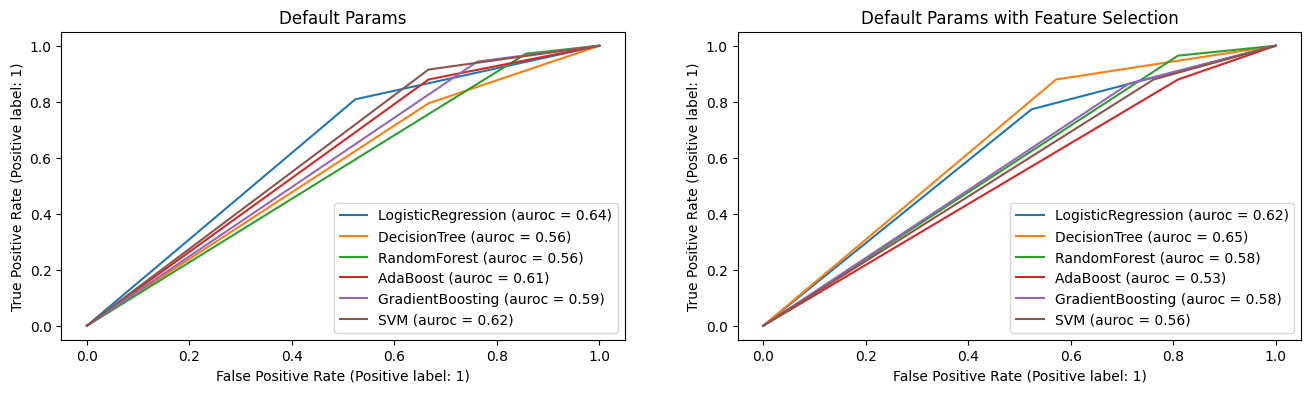

In [227]:
# roc_result  = [roc_score_result, optimal_roc_name, roc_optimal_selected_features]
# f1_result   = [f1_score_result, optimal_f1_name, f1_optimal_selected_features]

estimator_list = ["LogisticRegression", "DecisionTree", "RandomForest", "AdaBoost", "GradientBoosting", "SVM"]

fig, axs = plt.subplots(1,2, figsize = (16,4))

for each in estimator_list:

    auc_score = def_roc_result[0][each]
    y_predict = def_y_test_predict[each]

    sel_auc_score = sel_roc_result[0][each]
    sel_y_predict = sel_y_test_predict[each]

    RocCurveDisplay.from_predictions(y_true=y_test, y_pred = y_predict, ax = axs[0], label = each + " (auroc = {:.2f})".format(auc_score))
    RocCurveDisplay.from_predictions(y_true=y_test, y_pred = sel_y_predict, ax = axs[1], label = each + " (auroc = {:.2f})".format(sel_auc_score))

left_ax = axs[0]
right_ax = axs[1]
left_ax.set_title('Default Params')
right_ax.set_title('Default Params with Feature Selection')

plt.show()


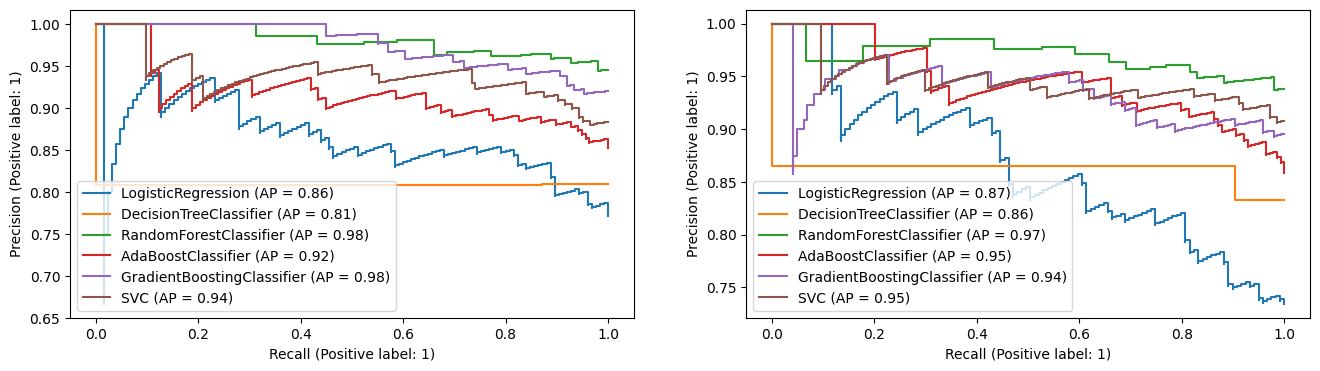

In [245]:
fig, axs = plt.subplots(1,2, figsize = (16,4))

for each in estimator_list:
    y_predict       = def_y_test_predict[each]
    sel_y_predict   = sel_y_test_predict[each]
    
    classifier = estimator_dict[each]
    classifier.fit(X_test, y_test)
    
    PrecisionRecallDisplay.from_estimator(classifier, X_test, y_predict, ax = axs[0])
    PrecisionRecallDisplay.from_estimator(classifier, X_test, sel_y_predict, ax = axs[1])

plt.show()